In [2]:
# Importing necessary libraries

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', False)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate

In [3]:
# Reading the input file

import os
cwd = os.getcwd()

train_values = cwd + "\\Source Data\\train_values.csv"
train_values = pd.read_csv(train_values)
train_labels = cwd + "\\Source Data\\train_labels.csv"
train_labels = pd.read_csv(train_labels)

test_values = cwd + "\\Source Data\\test_values.csv"
test_values = pd.read_csv(test_values)
test_id = test_values.patient_id
test = test_values.drop('patient_id', axis=1)

train = train_values.join(train_labels.set_index('patient_id'), on='patient_id', how='left')

In [4]:
# Data Prep

# re_categorize_values = {"chest_pain_type": {1: "one", 2: "two", 3: "three", 4: "four"},
#                        "fasting_blood_sugar_gt_120_mg_per_dl": {0: "Less than 120", 1: "Greater than 120"},
#                        "resting_ekg_results": {1: "one", 2: "two", 0: "zero"},
#                        "sex": {0: "female", 1: "male"},
#                        "exercise_induced_angina": {0: "No", 1: "Yes"}}

# train.replace(re_categorize_values, inplace=True)
# test.replace(re_categorize_values, inplace=True)

y = train['heart_disease_present']
x = train.drop(['heart_disease_present', 'patient_id'], axis=1)

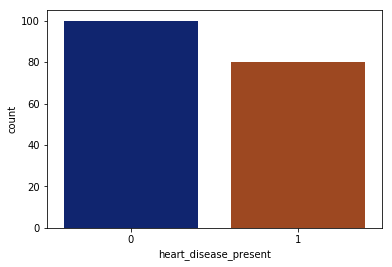

In [5]:
# Analyzing the train data

# train.isna().sum() # There are no missing values

# Checking the class imbalance

sns.countplot(train['heart_disease_present'], palette='dark')

# There is not much class imbalance. We may not need any over or under sampling

In [6]:
train['heart_disease_present'].value_counts()

0    100
1     80
Name: heart_disease_present, dtype: int64

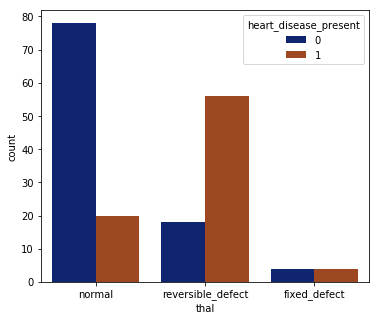

In [6]:
def generate_count_plots(x,y):
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    new_df = x.select_dtypes(include='object')
    total_cols = new_df.shape[1]
    item_counter = total_cols - 1
    
    # Generating the number of rows required
    
    rows = total_cols // 3
    remainder = total_cols%3
    
    if remainder != 0:
        rows = rows + 1
    
    # Generating code for the plots
    
    breadth = rows * 5
    plt.figure(figsize=(20,breadth))
    for i in range(total_cols):
        x_col = new_df.iloc[:,i]
        plt.subplot(rows, 3, i+1)
        sns.countplot(x_col, hue=y, palette='dark', dodge=True) # Try dodge=False for stacking, but numbers dont look right
        
    plt.show()

generate_count_plots(x,y)

From the above charts, there is a possibility that people that are male sex, and have type four chest pain type, and 
reversable defect thal, and exercise induced angina have high changes of having heart diseases

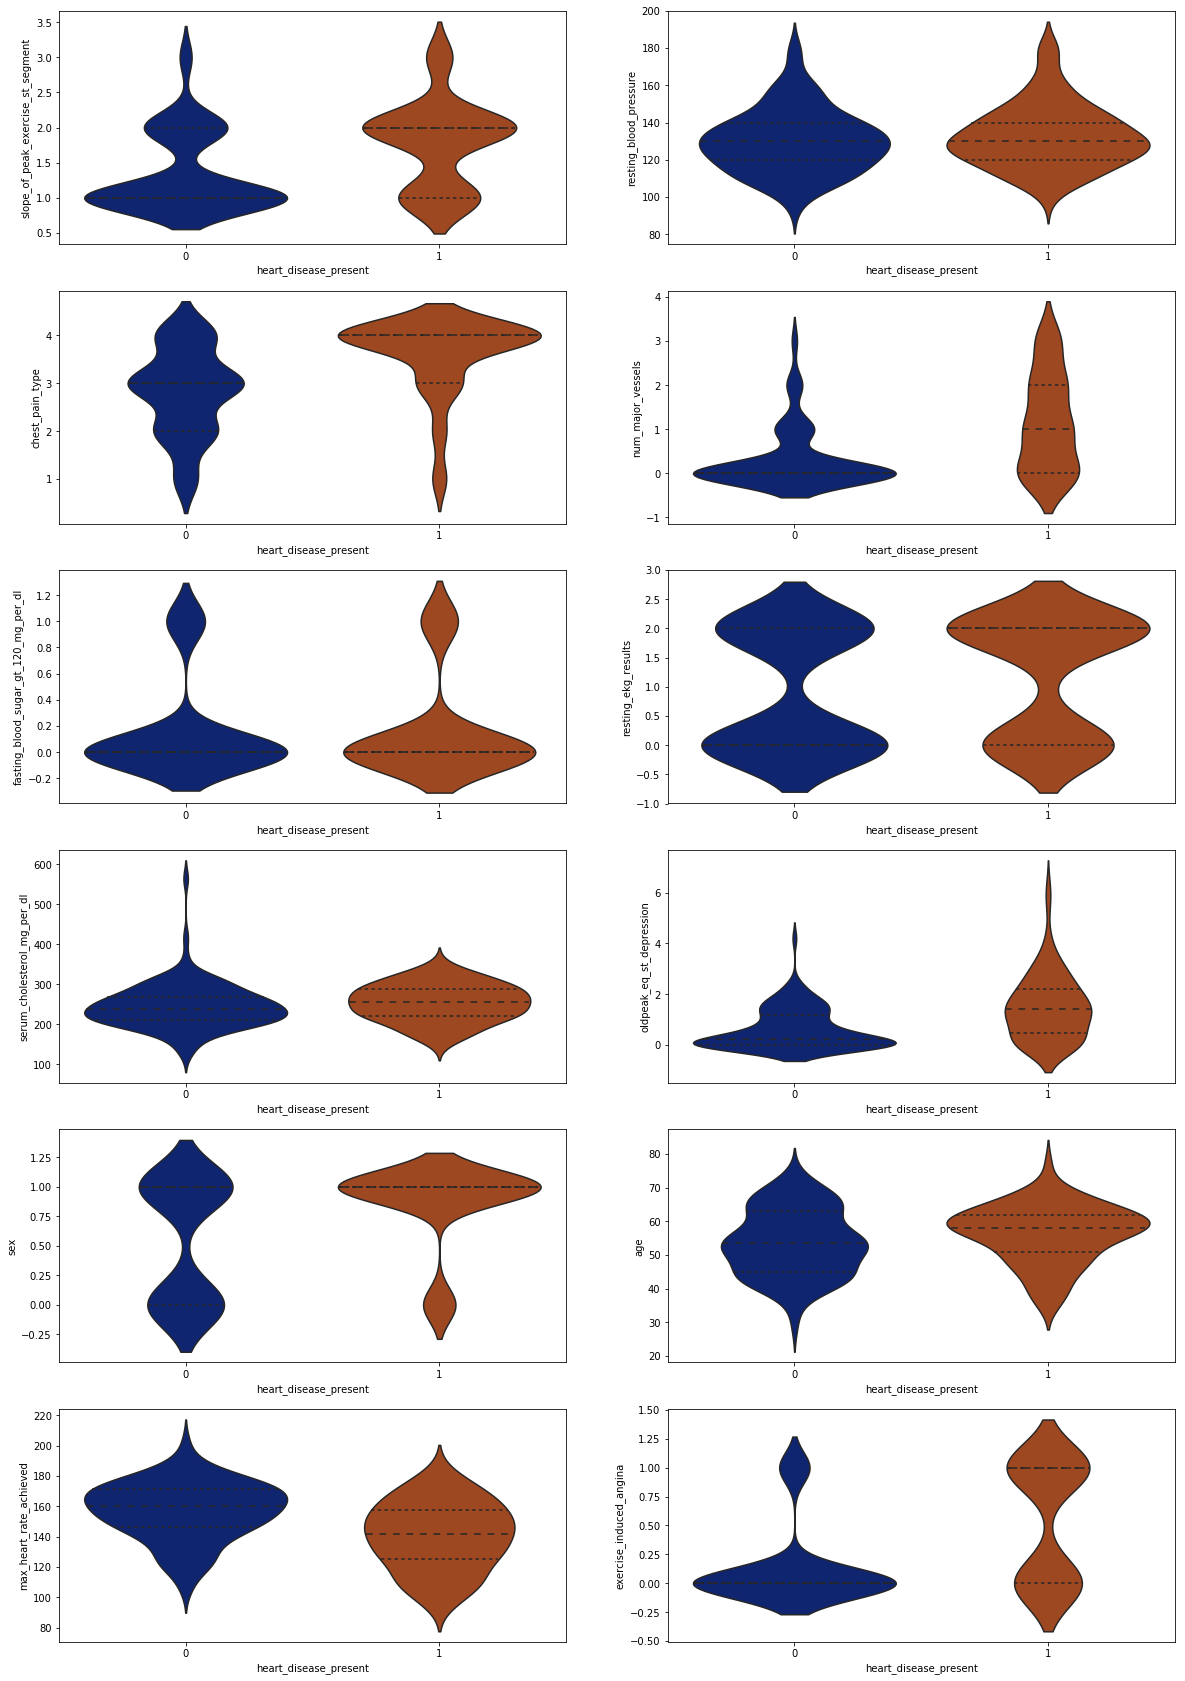

In [7]:
def generate_violin_plots(x,y):
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cols_to_include = ['int64', 'float64']
    new_df = x.select_dtypes(include=cols_to_include)
    total_cols = new_df.shape[1]
    item_counter = total_cols - 1
    
    # Generating the number of rows required
    
    rows = total_cols // 2
    remainder = total_cols%2
    
    if remainder != 0:
        rows = rows + 1
    
    # Generating code for the plots
    
    breadth = rows * 5
    plt.figure(figsize=(20,breadth))
    for i in range(total_cols):
        x_col = new_df.iloc[:,i]
        plt.subplot(rows, 2, i+1)
        sns.violinplot(y=x_col, x=y, palette='dark', inner='quartile')
        
    plt.show()

generate_violin_plots(x,y)

# Analysis:

1. slope of peak exercise st segment: Heart disease is more pronounced with people having slope 2 or greater
2. Resting blood pressure does not have much effect on heart disease (interesting)
3. Number of major vessels greater than 0 are more likely to get heart disease
4. Serum cholesterol does not have much effect
5. Oldpeak_eq_st_depression: Greater than 0 is more likely to get heart disease
6. Age between 50 to 70 more likely to have heart disease
7. Maximum heart rate achieved: Less than 140 may have higher chance of heart disease (see if the max heart rate achieved has any relation to age i.e. compare the distribution by age)

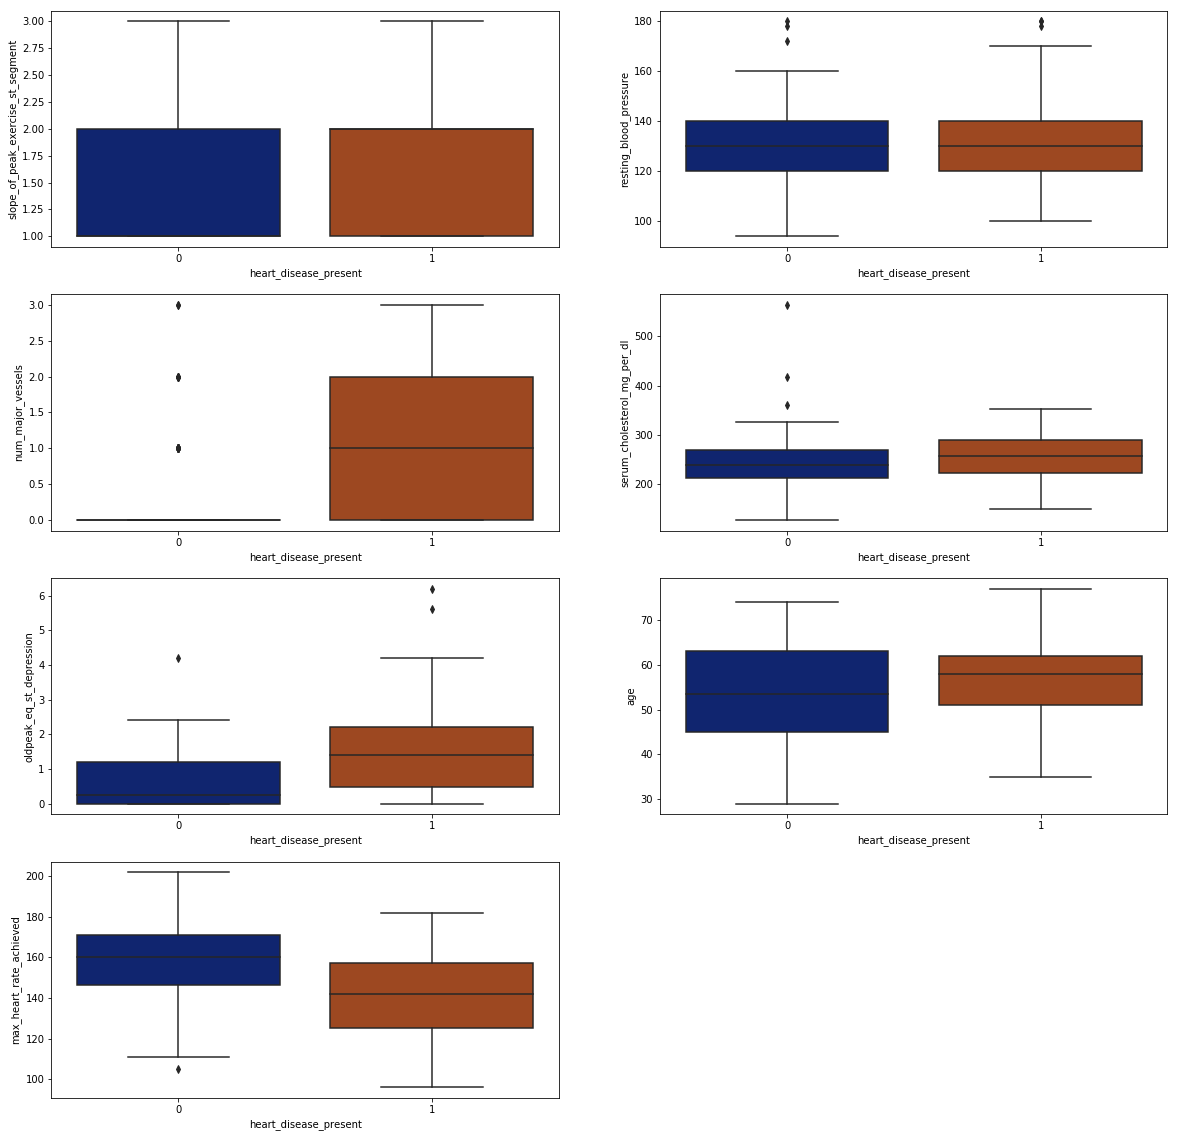

In [8]:
def generate_box_plots(x,y):
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cols_to_include =  ['int64', 'float64']
    new_df = x.select_dtypes(include=cols_to_include)
    total_cols = new_df.shape[1]
    item_counter = total_cols - 1
    
    # Generating the number of rows required
    
    rows = total_cols // 2
    remainder = total_cols%2
    
    if remainder != 0:
        rows = rows + 1
    
    # Generating code for the plots
    #color_item = x['sex']
    breadth = rows * 5
    plt.figure(figsize=(20,breadth))
    for i in range(total_cols):
        x_col = new_df.iloc[:,i]
        plt.subplot(rows, 2, i+1)
        sns.boxplot(y=x_col, x=y, palette='dark')
        #sns.boxplot(y=x_col, x=y, palette='dark', hue=color_item)
    plt.show()

generate_box_plots(x,y)

# Fixing Outliers

In [7]:
# Fixing outliers for the resting blood pressure
uplimit = (1.5 * (x.resting_blood_pressure.quantile(0.75) - x.resting_blood_pressure.quantile(0.25))) + x.resting_blood_pressure.quantile(0.75)
lowlimit =  x.resting_blood_pressure.quantile(0.25) - (1.5 * (x.resting_blood_pressure.quantile(0.75) - x.resting_blood_pressure.quantile(0.25)))
median_value = x['resting_blood_pressure'].median()

x['resting_blood_pressure'] = np.where((x.resting_blood_pressure > uplimit) | (x.resting_blood_pressure < lowlimit), median_value, x.resting_blood_pressure)
test['resting_blood_pressure'] = np.where((test.resting_blood_pressure > uplimit) | (test.resting_blood_pressure < lowlimit), median_value, test.resting_blood_pressure)

# Fixing outliers for the major num of vessels
uplimit = (1.5 * (x.num_major_vessels.quantile(0.75) - x.num_major_vessels.quantile(0.25))) + x.num_major_vessels.quantile(0.75)
lowlimit =  x.num_major_vessels.quantile(0.25) - (1.5 * (x.num_major_vessels.quantile(0.75) - x.num_major_vessels.quantile(0.25)))
median_value = x['num_major_vessels'].median()

x['num_major_vessels'] = np.where((x.num_major_vessels > uplimit) | (x.num_major_vessels < lowlimit), median_value, x.num_major_vessels)
test['num_major_vessels'] = np.where((test.num_major_vessels > uplimit) | (test.num_major_vessels < lowlimit), median_value, test.num_major_vessels)

# Fixing serum cholesterol mg per dl
uplimit = (1.5 * (x.serum_cholesterol_mg_per_dl.quantile(0.75) - x.serum_cholesterol_mg_per_dl.quantile(0.25))) + x.serum_cholesterol_mg_per_dl.quantile(0.75)
lowlimit =  x.serum_cholesterol_mg_per_dl.quantile(0.25) - (1.5 * (x.serum_cholesterol_mg_per_dl.quantile(0.75) - x.serum_cholesterol_mg_per_dl.quantile(0.25)))
median_value = x['serum_cholesterol_mg_per_dl'].median()

x['serum_cholesterol_mg_per_dl'] = np.where((x.serum_cholesterol_mg_per_dl > uplimit) | (x.serum_cholesterol_mg_per_dl < lowlimit), median_value, x.serum_cholesterol_mg_per_dl)
test['serum_cholesterol_mg_per_dl'] = np.where((test.serum_cholesterol_mg_per_dl > uplimit) | (test.serum_cholesterol_mg_per_dl < lowlimit), median_value, test.serum_cholesterol_mg_per_dl)

# Fixing old peak eq st depression
uplimit = (1.5 * (x.oldpeak_eq_st_depression.quantile(0.75) - x.oldpeak_eq_st_depression.quantile(0.25))) + x.oldpeak_eq_st_depression.quantile(0.75)
lowlimit =  x.oldpeak_eq_st_depression.quantile(0.25) - (1.5 * (x.oldpeak_eq_st_depression.quantile(0.75) - x.oldpeak_eq_st_depression.quantile(0.25)))
median_value = x['oldpeak_eq_st_depression'].median()

x['oldpeak_eq_st_depression'] = np.where((x.oldpeak_eq_st_depression > uplimit) | (x.oldpeak_eq_st_depression < lowlimit), median_value, x.oldpeak_eq_st_depression)
test['oldpeak_eq_st_depression'] = np.where((test.oldpeak_eq_st_depression > uplimit) | (test.oldpeak_eq_st_depression < lowlimit), median_value, test.oldpeak_eq_st_depression)

# Fixing max heart rate achieved
uplimit = (1.5 * (x.max_heart_rate_achieved.quantile(0.75) - x.max_heart_rate_achieved.quantile(0.25))) + x.max_heart_rate_achieved.quantile(0.75)
lowlimit =  x.max_heart_rate_achieved.quantile(0.25) - (1.5 * (x.max_heart_rate_achieved.quantile(0.75) - x.max_heart_rate_achieved.quantile(0.25)))
median_value = x['max_heart_rate_achieved'].median()

x['max_heart_rate_achieved'] = np.where((x.max_heart_rate_achieved > uplimit) | (x.max_heart_rate_achieved < lowlimit), median_value, x.max_heart_rate_achieved)
test['max_heart_rate_achieved'] = np.where((test.max_heart_rate_achieved > uplimit) | (test.max_heart_rate_achieved < lowlimit), median_value, test.max_heart_rate_achieved)


# Feature Engineering

In [8]:
# x['heart_risk'] = np.where(x.sex == 'male',0.25,0) + np.where(x.chest_pain_type == 'four',0.5,0) + np.where(x.exercise_induced_angina == 'Yes',0.5,0) + np.where(x.thal == 'reversible_defect',0.5,0) + np.where(x.slope_of_peak_exercise_st_segment >= 2,1,0) + np.where(x.num_major_vessels > 0, 1,0) + np.where(x.oldpeak_eq_st_depression > 0, 1,0) + np.where((x.age > 50) & (x.age < 70),0.5,0) + np.where(x.max_heart_rate_achieved < 140 , 1,0) 
# test['heart_risk'] = np.where(test.sex == 'male',0.25,0) + np.where(test.chest_pain_type == 'four',0.5,0) + np.where(test.exercise_induced_angina == 'Yes',0.5,0) + np.where(test.thal == 'reversible_defect',0.5,0) + np.where(test.slope_of_peak_exercise_st_segment >= 2,1,0) + np.where(test.num_major_vessels > 0, 1,0) + np.where(test.oldpeak_eq_st_depression > 0, 1,0) + np.where((test.age > 50) & (test.age < 70),0.5,0) + np.where(test.max_heart_rate_achieved < 140 , 1,0) 

x['heart_risk'] = np.where(x.sex == 1,0.25,0) + np.where(x.chest_pain_type == 4,0.5,0) + np.where(x.exercise_induced_angina == 1,0.5,0) +  np.where(x.thal == 'reversible_defect',0.5,0) + np.where(x.slope_of_peak_exercise_st_segment >= 2,1,0) + np.where(x.num_major_vessels > 0, 1,0) + np.where(x.oldpeak_eq_st_depression > 0, 1,0) + np.where((x.age > 50) & (x.age < 70),0.5,0) + np.where(x.max_heart_rate_achieved < 140 , 1,0) 

test['heart_risk'] = np.where(test.sex == 1,0.25,0) + np.where(test.chest_pain_type == 4,0.5,0) + np.where(test.exercise_induced_angina == 1,0.5,0) + np.where(test.thal == 'reversible_defect',0.5,0) + np.where(test.slope_of_peak_exercise_st_segment >= 2,1,0) + np.where(test.num_major_vessels > 0, 1,0) + np.where(test.oldpeak_eq_st_depression > 0, 1,0) + np.where((test.age > 50) & (test.age < 70),0.5,0) + np.where(test.max_heart_rate_achieved < 140 , 1,0) 




# # exercise induced angina = Yes, and slope of peak = 3 is always heart disease present (6 obs)
# x['angina_and_slope_of_peak'] = np.where((x.exercise_induced_angina =='Yes') & 
#                                          (x.slope_of_peak_exercise_st_segment==3),1,0)

# test['angina_and_slope_of_peak'] = np.where((test.exercise_induced_angina =='Yes') & 
#                                          (test.slope_of_peak_exercise_st_segment==3),1,0)

# # exercise induced angina = Yes, chest pain type = four, and num major vessels = 2, heart dis always present (0 obs)
# x['angina_chestPain_numVessels'] = np.where((x.exercise_induced_angina =='Yes') & (x.chest_pain_type == 'four') &
#                                          (x.num_major_vessels==2),1,0)

# test['angina_chestPain_numVessels'] = np.where((test.exercise_induced_angina =='Yes') & (test.chest_pain_type == 'four') &
#                                          (test.num_major_vessels==2),1,0)

# # exercise induced angina = Yes, and num major vessels = 3, heart dis always present (0 obs)
# x['angina_numVessels'] = np.where((x.exercise_induced_angina =='Yes') &
#                                          (x.num_major_vessels==3),1,0)

# test['angina_numVessels'] = np.where((test.exercise_induced_angina =='Yes') &
#                                          (test.num_major_vessels==3),1,0)

# # sex = female, and num major vessels = 3, heart dis always present (3 obs)
# x['sex_numVessels'] = np.where((x.sex =='female') & (x.num_major_vessels==3),1,0)
# test['sex_numVessels'] = np.where((test.sex =='female') &(test.num_major_vessels==3),1,0)

# # max HR achieved < 146, and num major vessels = 3, heart dis always present (10 obs)
# x['maxHR_numVessels'] = np.where((x.max_heart_rate_achieved < 146) & (x.num_major_vessels==3),1,0)
# test['maxHR_numVessels'] = np.where((test.max_heart_rate_achieved < 146) &(test.num_major_vessels==3),1,0)

# # thal=normal, and num major vessels in 0&1, chest pain type =2, heart dis never present (19 obs)
# x['thal_numVessels_chestPain'] = np.where((x.thal=='normal') & (x.num_major_vessels.isin([0,1])) &
#                                           (x.chest_pain_type=='two') ,1,0)
# test['thal_numVessels_chestPain'] = np.where((test.thal=='normal') & (test.num_major_vessels.isin([0,1])) &
#                                           (test.chest_pain_type=='two') ,1,0)

# # thal=reversible_defect, and slope of peak.. =2 , chest pain type =4, and max HR > 105 heart dis always present (25 obs)
# x['thal_slope_chestPain_maxHR'] = np.where((x.thal=='reversible_defect') & (x.max_heart_rate_achieved > 105 ) &
#                                           (x.chest_pain_type=='four') & (x.slope_of_peak_exercise_st_segment==2) ,1,0)
# test['thal_slope_chestPain_maxHR'] = np.where((test.thal=='reversible_defect') & (test.max_heart_rate_achieved > 105) &
#                                           (test.chest_pain_type=='four') & (test.slope_of_peak_exercise_st_segment==2) ,1,0)

# # resting ekg = two, thal = reversible defect, and num major vessels in 1 & 3 heart dis always present (12 obs)
# x['restEkg_thal_numVessels'] = np.where((x.thal=='reversible_defect') & (x.resting_ekg_results=='two' ) &
#                                           (x.num_major_vessels.isin([1,3])),1,0)
# test['restEkg_thal_numVessels'] = np.where((test.thal=='reversible_defect') & (test.resting_ekg_results=='two' ) &
#                                           (test.num_major_vessels.isin([1,3])),1,0)

# # slope of peak = 1, sex=female, chest pain = four and num major vessels in 1 & 0 heart dis never present (21 obs)
# x['slope_sex_chestPain_numVessels'] = np.where((x.slope_of_peak_exercise_st_segment==1) &
#                                         (x.sex=='female' ) & (x.num_major_vessels.isin([1,0])) &
#                                         (x.chest_pain_type=='four'),1,0)

# test['slope_sex_chestPain_numVessels'] = np.where((test.slope_of_peak_exercise_st_segment==1) &
#                                         (test.sex=='female' ) & (test.num_major_vessels.isin([1,0])) &
#                                         (test.chest_pain_type=='four'),1,0)

# # major vessels in 2 & 3, exercise induced =1, and chest pain = four heart dis always present (15 obs)
# x['numVessels_angina_chestPain'] = np.where((x.num_major_vessels.isin([2,3])) &
#                                         (x.exercise_induced_angina==1) & (x.chest_pain_type=='four'),1,0)

# test['numVessels_angina_chestPain'] = np.where((test.num_major_vessels.isin([2,3])) &
#                                         (test.exercise_induced_angina==1) & (test.chest_pain_type=='four'),1,0)

In [71]:
# # Export the feature engineered dataset for validation

# validation_data = pd.concat([x,y],axis=1)
# validation_data.to_csv(cwd + "\\Output Data\\Validation_with_labels.csv", index=False)

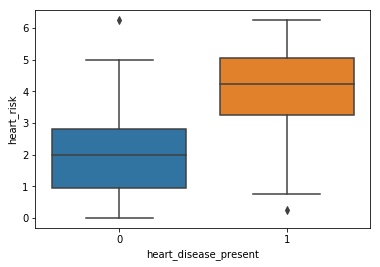

In [9]:
sns.boxplot(y=x['heart_risk'], x=y)

In [10]:
x = pd.get_dummies(x)
test = pd.get_dummies(test)

In [94]:
# # OVERSAMPLING TRAINING DATA
# from imblearn.over_sampling import SMOTE

# os = SMOTE(random_state=0)
# columns = x_train.columns
# x_train,y_train =os.fit_sample(x_train, y_train)
# x_train = pd.DataFrame(data=x_train,columns=columns )
# y_train= pd.DataFrame(data=y_train,columns=['target'])

In [11]:
# Train and Validation Split

from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x,y, stratify=y, random_state=1, test_size=0.25)

# XGBOOST IMPLEMENTATION

# Tuning the number of estimators

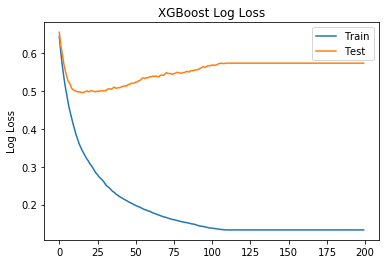

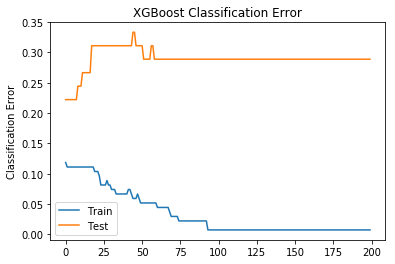

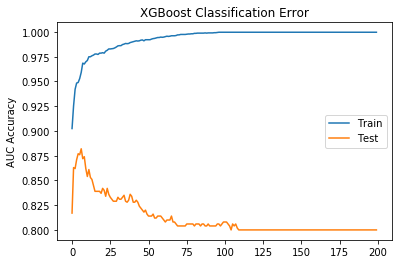

In [12]:
model = XGBClassifier(
 learning_rate = 0.1,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 subsample=1,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1.25,
 reg_alpha=1,
 seed=11)


eval_set = [(x_train, y_train), (x_validation, y_validation)]
eval_metric = ["auc","logloss", "error"]
model.fit(x_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

#from matplotlib import pyplot
# retrieve performance metrics\n
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# plot classification error

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC Accuracy')
plt.title('XGBoost Classification Error')
plt.show()


Model Report

Train Accuracy
Accuracy : 0.9926
AUC Score (Train): 0.999778

Test Accuracy
Accuracy : 0.7111
AUC Score (Train): 0.800000


Text(0, 0.5, 'Feature Importance Score')

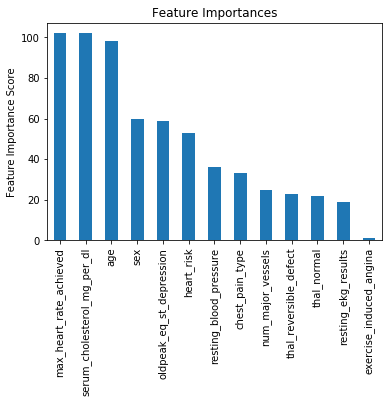

In [13]:
#Print model report:

train_pred = model.predict(x_train)
train_pred_prob = model.predict_proba(x_train)[:,1]

test_pred = model.predict(x_validation)
test_pred_prob = model.predict_proba(x_validation)[:,1]

print ("\nModel Report")
print ("\nTrain Accuracy")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, train_pred))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, train_pred_prob))
print ("\nTest Accuracy")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_validation.values, test_pred))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_validation, test_pred_prob))

feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

From the graphs above, the number of estimators is around 30 and 60. Let us try a varied range of learning rate from 0.01 to 0.1, and also the estimators from 30 to 200

# Tuning parameters using the top 10 features

In [14]:
imp_features = feat_imp.index[0:10]
x_train = x_train[imp_features]
x_validation = x_validation[imp_features]
test = test[imp_features]

# Tuning Estimators and Learning Rate

In [24]:
parameters = {
    'n_estimators': range(10,30,1),
    'learning_rate': [0.01, 0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,  0.2, 0.21, 0.22, 0.23, 0.25, 0.30, 0.35],
}

model_gridSearch = GridSearchCV(estimator = XGBClassifier(max_depth=3, min_child_weight=1, subsample=1,  scale_pos_weight=1.25,
                                                          colsample_bytree=0.9, objective='binary:logistic',
                                                         reg_lambda=1, reg_alpla=0, seed=9),
                                param_grid = parameters, scoring='neg_log_loss', n_jobs=-1, iid=False, cv=5)

model_gridSearch.fit(x_train, y_train)

print("Best Params: %r" % model_gridSearch.best_params_)
print("Best Score: %1.4f\n" % model_gridSearch.best_score_)
tuned_model = model_gridSearch.best_estimator_
# means = model_gridSearch.cv_results_['mean_test_score']
# stds = model_gridSearch.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, model_gridSearch.cv_results_['params']): 
#     print("Mean: %0.4f | Std: %0.4f | Params:  %r" % (mean, std * 2, params))

Best Params: {'learning_rate': 0.23, 'n_estimators': 12}
Best Score: -0.3990



From the above search, let us use the n_estimators to be 12, and the learning rate to be 0.23

# Tuning the max depth

In [28]:
parameters = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
}

model_gridSearch = GridSearchCV(estimator = tuned_model,
                                param_grid = parameters, scoring='neg_log_loss', n_jobs=-1, iid=False, cv=5)

model_gridSearch.fit(x_train, y_train)

print("Best Params: %r" % model_gridSearch.best_params_)
print("Best Score: %1.4f\n" % model_gridSearch.best_score_)
tuned_model = model_gridSearch.best_estimator_

# means = model_gridSearch.cv_results_['mean_test_score']
# stds = model_gridSearch.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, model_gridSearch.cv_results_['params']): 
#     print("Mean: %0.4f | Std: %0.4f | Params:  %r" % (mean, std * 2, params))

Best Params: {'max_depth': 6}
Best Score: -0.3887



A max depth of 6 has the lest log loss error.. Let us finalize on the max depth 6

# Tuning the min child weight

In [29]:
parameters = {
    'min_child_weight': [0.1, 0.5, 0.01, 0.06, 1,2,3,4, 4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6]
}

model_gridSearch = GridSearchCV(estimator = tuned_model,
                                param_grid = parameters, scoring='neg_log_loss', n_jobs=-1, iid=False, cv=5)

model_gridSearch.fit(x_train, y_train)

print("Best Params: %r" % model_gridSearch.best_params_)
print("Best Score: %1.4f\n" % model_gridSearch.best_score_)
tuned_model = model_gridSearch.best_estimator_

# means = model_gridSearch.cv_results_['mean_test_score']
# stds = model_gridSearch.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, model_gridSearch.cv_results_['params']): 
#     print("Mean: %0.4f | Std: %0.4f | Params:  %r" % (mean, std * 2, params))

Best Params: {'min_child_weight': 1}
Best Score: -0.3887



# Tuning the regularization parameters

In [31]:
parameters = {
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1],
    'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 4, 16, 32, 64]
}

model_gridSearch = GridSearchCV(estimator = tuned_model,
                                param_grid = parameters, scoring='neg_log_loss', n_jobs=-1, iid=False, cv=5)

model_gridSearch.fit(x_train, y_train)

print("Best Params: %r" % model_gridSearch.best_params_)
print("Best Score: %1.4f\n" % model_gridSearch.best_score_)
tuned_model = model_gridSearch.best_estimator_

# means = model_gridSearch.cv_results_['mean_test_score']
# stds = model_gridSearch.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, model_gridSearch.cv_results_['params']): 
#     print("Mean: %0.4f | Std: %0.4f | Params:  %r" % (mean, std * 2, params))

Best Params: {'reg_alpha': 0, 'reg_lambda': 1}
Best Score: -0.3887



# Running one more iteration for alpha

In [103]:
# parameters = {
#     'reg_lambda': [i/100.0 for i in range(5,15,1)]
# }

# model_gridSearch = GridSearchCV(estimator = XGBClassifier(n_estimators=29, max_depth=2, min_child_weight=1, subsample=1,
#                                                           colsample_bytree=0.9, objective='binary:logistic',
#                                                           seed=9, learning_rate=0.1, reg_lambda=0),
#                                 param_grid = parameters, scoring='neg_log_loss', n_jobs=-1, iid=False, cv=5)

# model_gridSearch.fit(x_train, y_train)

# print("Best Params: %r" % model_gridSearch.best_params_)
# print("Best Score: %1.4f\n" % model_gridSearch.best_score_)

# # means = model_gridSearch.cv_results_['mean_test_score']
# # stds = model_gridSearch.cv_results_['std_test_score']
# # for mean, std, params in zip(means, stds, model_gridSearch.cv_results_['params']): 
# #     print("Mean: %0.4f | Std: %0.4f | Params:  %r" % (mean, std * 2, params))

In [32]:
tuned_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.23, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=12, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_alpla=0, reg_lambda=1, scale_pos_weight=1.25,
       seed=9, silent=None, subsample=1, verbosity=1)

Let us finally run the model using the above optimized parameters

In [33]:
# Extracting the list of important features

model = tuned_model
    
#Fit the algorithm on the data
model.fit(x_train, y_train,eval_metric='logloss')
        
#Print model report:

train_pred = model.predict(x_train)
train_pred_prob = model.predict_proba(x_train)[:,1]

test_pred = model.predict(x_validation)
test_pred_prob = model.predict_proba(x_validation)[:,1]

print ("\nModel Report")
print ("\nTrain Accuracy")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, train_pred))
print ("Logloss : %.4g" % metrics.log_loss(y_train.values, train_pred))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, train_pred_prob))
print ("\nTest Accuracy")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_validation.values, test_pred))
print ("Losloss : %.4g" % metrics.log_loss(y_validation.values, test_pred))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_validation, test_pred_prob))


Model Report

Train Accuracy
Accuracy : 0.9926
Logloss : 0.2558
AUC Score (Train): 0.999778

Test Accuracy
Accuracy : 0.6889
Losloss : 10.75
AUC Score (Train): 0.802000


In [34]:
# Predicting the test data set

test_pred_prob = model.predict_proba(test)[:,1]

In [35]:
output = pd.DataFrame({'patient_id': test_id, 'heart_disease_present':test_pred_prob})
output.to_csv(cwd + "\\Output Data\\Submission 6 - XGBoost 0.68 accuracy with Imp Features preserving dtypes.csv", index=False)

In [107]:
# XGBoost Parameters: https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.kaggle.com/cast42/xg-cv
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/
# https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/

# XGBoost vs sklearn wrapper: https://stackoverflow.com/questions/46943674/how-to-get-predictions-with-xgboost-and-xgboost-using-scikit-learn-wrapper-to-ma

# Finetuning Parameters

# https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
# https://towardsdatascience.com/selecting-optimal-parameters-for-xgboost-model-training-c7cd9ed5e45e
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/